接着上一阶段，我们了解了如何去处理类别不平衡数据，这一阶段，我们把重点放在数据分析的层面，那么第一步就是处理缺失值！


# 缺失值处理

我们知道在这个数据集中，-1代表着缺失值，那么我们对付缺失值无非就是两招：

- 移除
- 填充

移除比较简单，要么直接干掉整个列（使用`drop(axis=1)`），要么去除所有含缺失值的行（使用`dropna()`）。

前提是，缺失值在整个列的比例达到40%以上，我们才可以drop列，不然我们就要采取下一种方法，也就是填充。

**建议大家先阅读一下下面的文章链接**👇👇👇

https://gitee.com/gzjzg/data-preparation-crash-course/tree/master/HandleMissingValues

In [1]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

In [2]:
# 读取数据

train = pd.read_csv("../../train.gz")
test = pd.read_csv("../../test.gz")

In [3]:
# 全集
fullset = pd.concat([train,test],ignore_index=True)

## 缺失值诊断

那么在诊断数据缺失值时，一定要搞清楚为什么会存在缺失值，这将极大影响我们接下来如何处理缺失值！

先介绍一下「缺失类型」

- MCAR (Missing completely at Random)
- MAR (Missing at Random)
- MNAR (Missing not at Random)

MCAR 的意思是“缺失与任何值之间没有关系”。因此，在这种情况下，可以删除缺失值。为此，可以删除列缺失值；最小化丢失数据或删除行缺失值。

MAR 的意思是“缺失与其他观察到的数据之间存在系统关系，但与缺失数据无关”。

最后，MNAR 的意思是“缺失与它的值之间存在关系，缺失或非缺失”。

### 使用元数据

这里可以借助meta元数据来查看缺失值情况！

In [4]:
def meta(train,test,missing_values = -1,cols_ignore_missing = []):
    
    df = pd.concat([train,test]).reset_index(drop=True).fillna('未知')
    data = []
    for col in df.columns:
        # 定义role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'feature'
        
        # 定义category
        if 'ind' in col:
            category = 'individual'
        elif 'car' in col:
            category = 'car'
        elif 'calc' in col:
            category = 'calculated'
        elif 'reg' in col:
            category = 'region'
        else:
            category = 'other'
        
        
        # 定义 level of measurements
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col[-3:] or col == 'id':
            level = 'nominal'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() > 1:
            level = 'interval'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() <= 1:
            level = 'ratio'
        elif df[col].dtype == 'int64':
            level = 'ordinal'
            
        # 定义 data type
        dtype = df[col].dtype
        
        # 定义 unique
        if col == 'id' or df[col].dtype == 'float64':
            uniq = 'Ignore'
        else:
            if col in cols_ignore_missing:
                uniq = df[col].nunique()
            else:
                uniq = df[col].replace({missing_values:np.nan}).nunique()
                
        # 定义 cardinality
        if uniq == 'Ignore':
            cardinality = 'Ignore'
        elif uniq <= 10:
            cardinality = 'Low Cardinality'
        elif uniq <= 30:
            cardinality = 'Medium Cardinality'
        else:
            cardinality = 'High Cardinality'
        
        # 定义 missing
        if col in cols_ignore_missing:
            missing = 0
        else:
            missing = sum(df[col] == missing_values)
            
        # 定义 missing percent
        missing_percent = f'{missing}({round(missing*100/len(df),2)}%)'
        
        # 定义 imputation
        if missing > df.shape[0]*0.4:
            imputation = 'remove'
        elif missing > 0:
            if level == 'binary' or level == 'nominal':
                imputation = ('mode')
            if level == 'ordinal':
                imputation = ('mode','median')
            if level == 'interval' or level == 'ratio':
                imputation = ('mode','median','mean')        
        else:
            imputation = "No Missing"
            
        # 定义 keep
        keep = True
        if col  == 'id' or imputation == 'remove':
            keep = False
        col_dict = {
            'colname': col,
            'role': role,
            'category': category,
            'level': level,
            'dtype': dtype,
            'cardinality': uniq,
            'cardinality_level':cardinality,
            'missing': missing,
            'missing_percent': missing_percent,
            'imputation':imputation,
            'keep': keep,
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=list(col_dict.keys()))
    meta.set_index('colname', inplace=True)
    
    return meta

In [5]:
metadata = meta(train,test)

<div class="alert alert-block alert-success"><b>Step 1</b>: 尝试基于meta找出所有含有缺失值的变量，并从大到小排序。    

</div>

In [6]:
missing_data = '你的代码'

In [7]:
missing_data

,missing,missing_percent,imputation
colname,,,
ps_car_03_cat,1028142,1028142(69.09%),remove
ps_car_05_cat,666910,666910(44.82%),remove
ps_reg_03,269456,269456(18.11%),"(mode, median, mean)"
ps_car_14,106425,106425(7.15%),"(mode, median, mean)"
ps_car_07_cat,28820,28820(1.94%),mode
ps_ind_05_cat,14519,14519(0.98%),mode
ps_car_09_cat,1446,1446(0.1%),mode
ps_ind_02_cat,523,523(0.04%),mode
ps_car_01_cat,267,267(0.02%),mode


<div class="alert alert-block alert-success"><b>Step 2</b>: 所以哪些变量需要drop掉？哪些需要填充？该采取什么样的方法填充？在meta中能找到一些启发么？

</div>

In [8]:
cols_to_drop = '你的代码'

In [9]:
cols_to_imp = missing_data.index[2:].to_list()
cols_to_imp_3m = missing_data[missing_data.imputation == ('mode', 'median', 'mean')].index.to_list()
cols_to_imp_2m = missing_data[missing_data.imputation == ('mode', 'median')].index.to_list()
cols_to_imp_1m = missing_data[missing_data.imputation == ('mode')].index.to_list()

以上，是单变量填充的思考方式，也是比较简单易理解的方法。

什么是**单变量填充（univariate imputation）**？

**就是当前列的缺失值只能通过当前列的信息填充，跟其他列无关。**

后面，会给大家介绍如何单变量填充！

### 使用missingno

In [10]:
import missingno as msno

<AxesSubplot:>

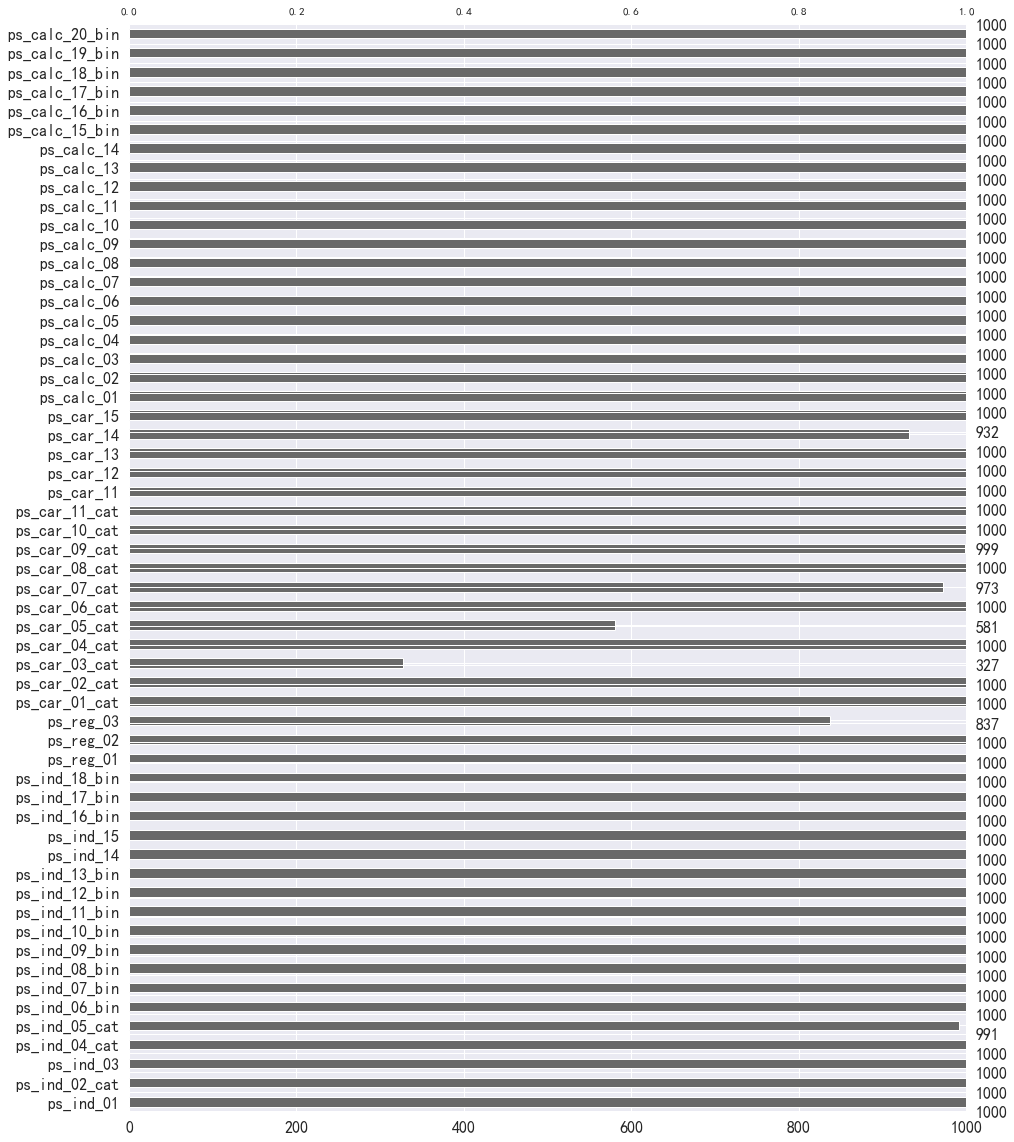

In [11]:
msno.bar(fullset.drop(['id','target'],axis=1).replace(-1,np.nan).sample(1000),figsize = [15,20]) 

<AxesSubplot:>

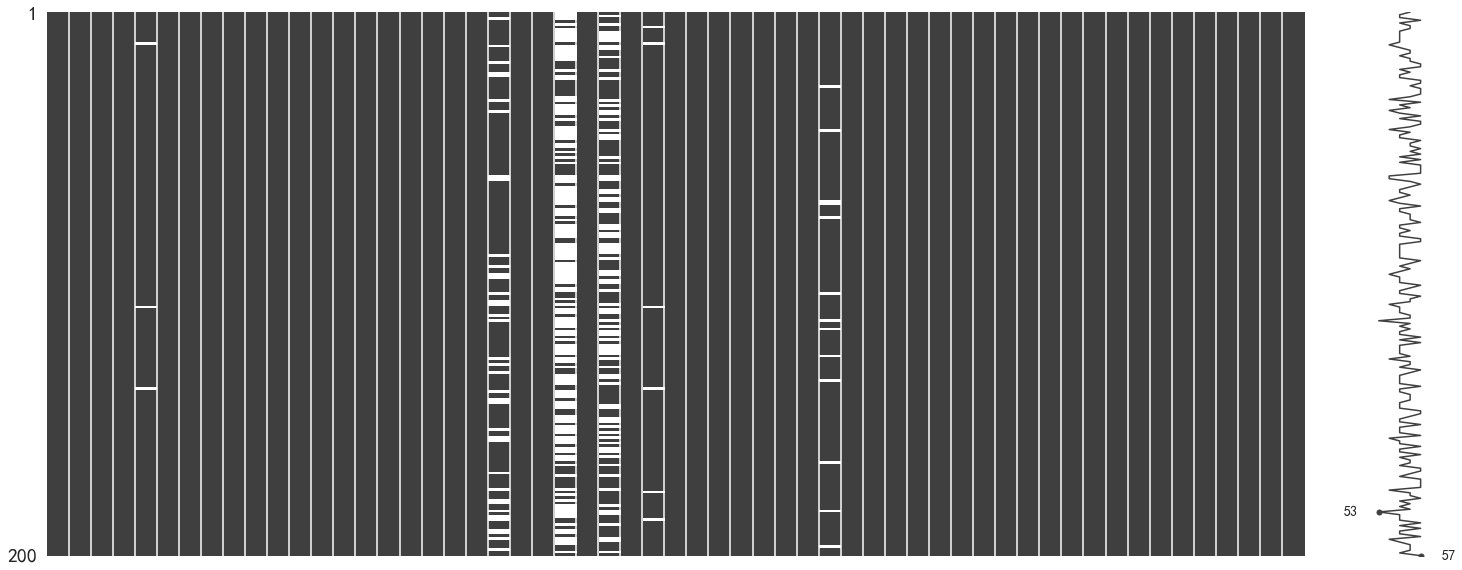

In [12]:
msno.matrix(fullset.drop(['id','target'],axis=1).sample(200).replace(-1,np.nan)) 

# 更清晰的展示缺失值的分布，但是在这里是无效的，主要用于时间序列数据，但这个数据不是！

<AxesSubplot:>

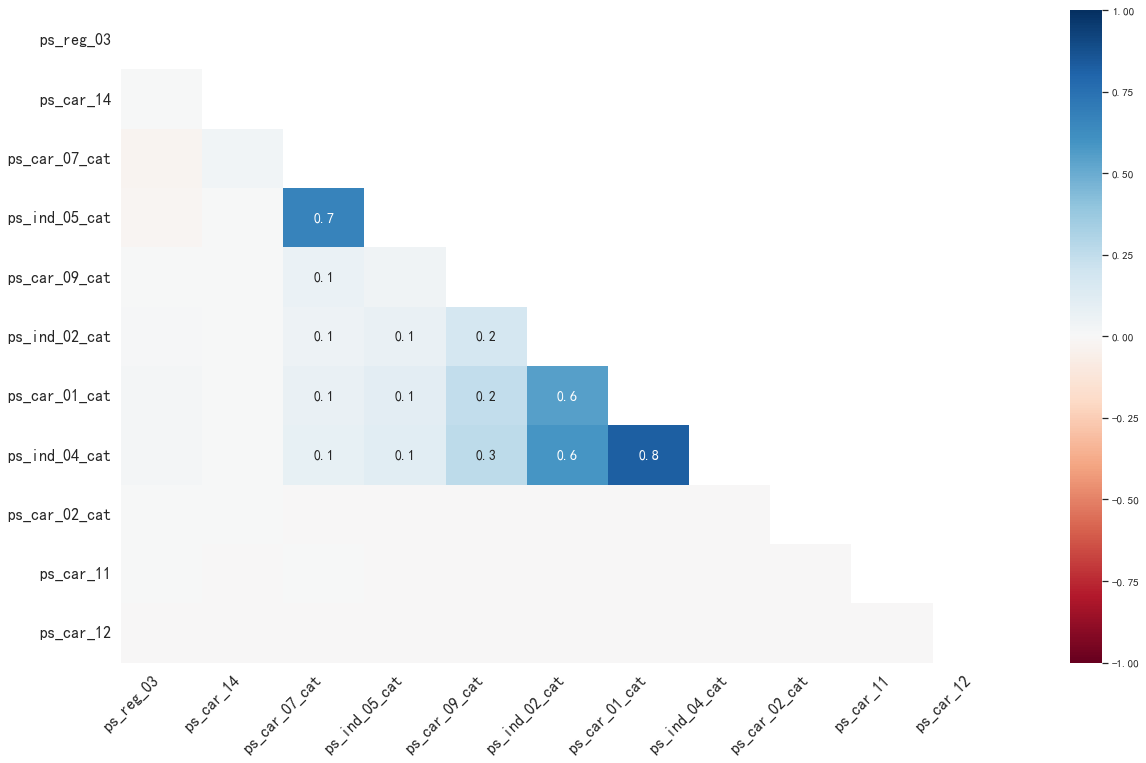

In [13]:
msno.heatmap(fullset[cols_to_imp].replace(-1,np.nan))

<AxesSubplot:>

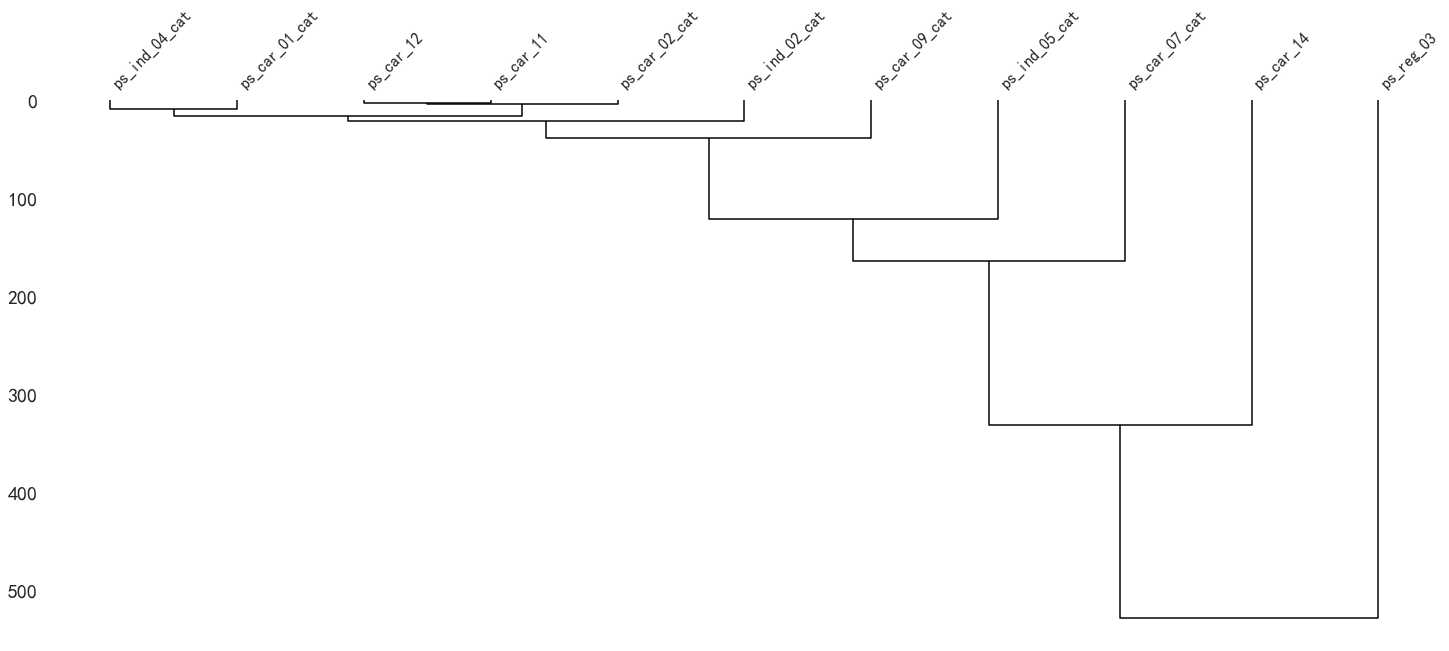

In [14]:
msno.dendrogram(fullset[cols_to_imp].replace(-1,np.nan))

## 缺失值填充

- 单变量
- 多变量

> 单变量填充：每一列填充缺失值都必须使用本列的信息，不能使用其他列的信息。


> 多变量填充：可以借助其他列的信息。

### 多变量填充

通过上图可以看出每一对变量之间的缺失值关联程度，比如：

ps_car_01_cat的缺失就会导致ps_ind_04_cat的缺失，是正向的关系，且关联程度很大！

所以，接下来给大家介绍【多变量填充】，如果变量之间的缺失值生成原因有关联（上方的heatmap）

从上图可以看出，我们尝试用多变量填充方法去填充有关联的变量！

- ps_ind_05_cat | ps_car_07_cat
- ps_car_01_cat | ps_ind_02_cat | ps_ind_04_cat
- ps_reg_03 | ps_car_14 （连续型）

以上这两组，组间有较强的缺失值关联度，最后一组是连续型变量，我们现在来介绍方法：

这里为大家介绍以下几个多变量填充方法：

https://scikit-learn.org/stable/modules/impute.html

---

- Multivariate Imputation By Chained Equations (MICE) 
- KNN

那么我们分别来用这两个包实现一下！

In [15]:
set1 = ['ps_ind_05_cat','ps_car_07_cat']
set2 = ['ps_car_01_cat','ps_ind_02_cat','ps_ind_04_cat']
set3 = ['ps_reg_03','ps_car_14']

#### MICE

MICE是非常简单好理解且比较常用的多变量填充方法，在sklearn和impyute上都可以实现，让我们来看看其原理吧！

In [16]:
IFrame(width="853",height="480",src = "https://www.youtube.com/embed/WPiYOS3qK70")

In [17]:
%%time

from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=123)

imp_mean = IterativeImputer(estimator=rf, missing_values=-1, random_state=0)
set1_imp = imp_mean.fit_transform(train[set1])

Wall time: 3.62 s


In [18]:
%%time
set2_imp = imp_mean.fit_transform(train[set2])

Wall time: 14.9 s


仅仅从2个变量加到3个变量，运行时间就指数型增加，expensive！

可以看到，对于set1来说，这方法并不适用于填充类别型变量，直接把整数给填充成小数了，如果再把小数直接round，那么就跟直接众数填充（单变量填充）没啥区别。

对于set2，貌似没有直接按照众数填充，把缺失值填充到8左右，但是后面的缺失值实在太少了，几十万的数据，只有几百个缺失值，确实不够看，而且这种填充对本来的数据影响不大。

那么再来试试2个连续型变量吧！

In [19]:
%%time
set3_imp = imp_mean.fit_transform(train[set3])

Wall time: 2min 19s


C:\Users\gzjgz\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



说明这个算法没有收敛，那么我们来看一下分布！

In [20]:
pd.DataFrame(set3_imp,columns = set3)

,ps_reg_03,ps_car_14
0,0.718070,0.370810
1,0.766078,0.388716
2,0.855884,0.347275
3,0.580948,0.294958
4,0.840759,0.365103
...,...,...
595207,0.692820,0.385487
595208,1.382027,0.378471
595209,0.659071,0.398748
595210,0.698212,0.384968


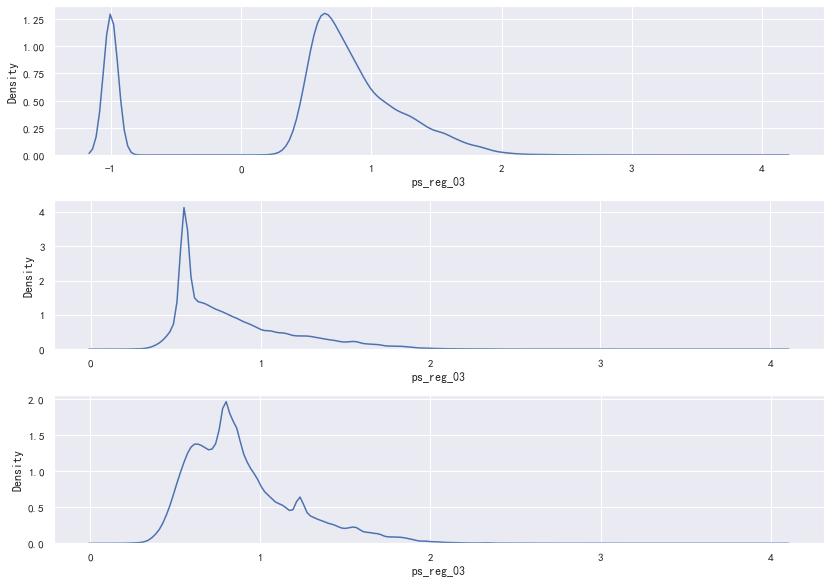

In [21]:
plt.subplot(3,1,1)
sns.kdeplot(train[set3[0]])
plt.subplot(3,1,2)
sns.kdeplot(train[set3[0]].replace(-1,np.nan).fillna(train[set3[0]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[0]])

plt.tight_layout()

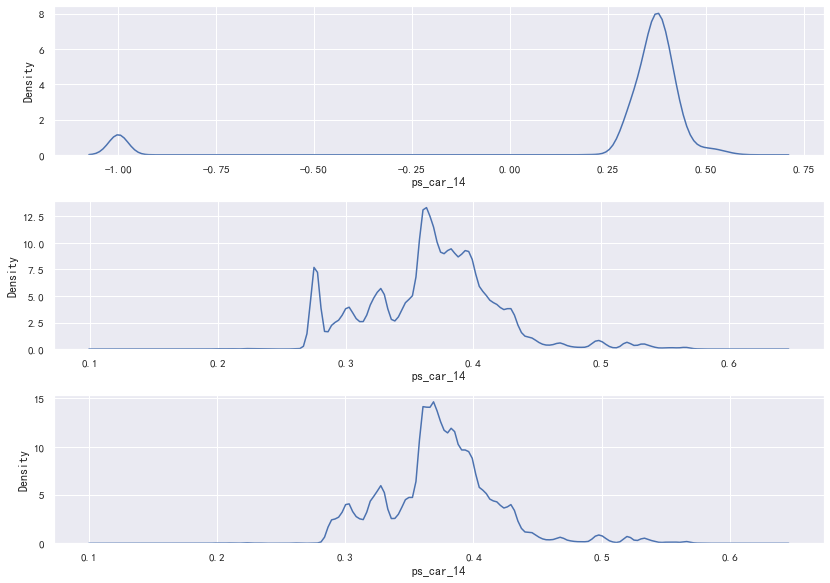

In [22]:
plt.subplot(3,1,1)
sns.kdeplot(train[set3[1]])
plt.subplot(3,1,2)
sns.kdeplot(train[set3[1]].replace(-1,np.nan).fillna(train[set3[1]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[1]])

plt.tight_layout()

可以看出，MICE可以更好地吻合原变量的概率分布，所以我们选择使用MICE填充！

In [23]:
train[set3] = pd.DataFrame(set3_imp,columns = set3)

#### KNN

In [24]:
%%time
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(missing_values=-1,n_neighbors=2000)
# imputer.fit_transform(train[set1])

# Wall time: 7min 35s

Wall time: 0 ns


这个计算时间真的是让我望而却步了，大家在面对大型数据集还是慎用吧，KNN真是让我害怕！

### 单变量填充

单变量填充就比较简单了，请大家直接看我的笔记！

https://gitee.com/gzjzg/data-preparation-crash-course/blob/master/HandleMissingValues/01-Missing_Data_Proceesing_Basis.ipynb

主要有：

- fillna
- replace
- SimpleImputer
- Intepolate

这里我们主要使用SimpleImputer来填充！

不同的strategy形成不同的填充模式，

- If "<font color=red>mean</font>", then replace missing values using the mean along each column. Can only be used with numeric data.
- If "<font color=red>median</font>", then replace missing values using the median along
  each column. Can only be used with numeric data.
- If "<font color=red>most_frequent</font>", then replace missing using the most frequent
  value along each column. Can be used with strings or numeric data.
  If there is more than one such value, only the smallest is returned.
- If "<font color=red>constant</font>", then replace missing values with fill_value. Can be
  used with strings or numeric data.

In [25]:
# 缺失值处理（1）
IFrame(width="853",height="480",src = "http://v.xiaohongshu.com/01e23d740163edea018370037fc00fcb53_259.mp4?sign=ddc7525337222487fe99a77c32fa499e&t=6266c580")

In [26]:
# 缺失值处理（2）
IFrame(width="853",height="480",src = "http://v.xiaohongshu.com/01e24207c120206a018370037fd1f059f3_259.mp4?sign=b402a6d59e6449d0759e2a5953ae6a1c&t=6266c580")

In [27]:
# 缺失值处理（3）
IFrame(width="853",height="480",src = "http://v.xiaohongshu.com/pre_post/01e248713d22925d018370037feafe1133_259.mp4?sign=ceb965f12f645a52e0a76af7ac953a53&t=6266c580")

In [28]:
from sklearn.impute import SimpleImputer 

In [29]:
mode_imputer = SimpleImputer(missing_values = -1, strategy='most_frequent',add_indicator=True)

In [30]:
missing_data[4:]
# 这些是还没填充的变量，我们就都用mode来填充，
# 因为最后两个缺失值太少了，没有影响。

,missing,missing_percent,imputation
colname,,,
ps_car_07_cat,28820,28820(1.94%),mode
ps_ind_05_cat,14519,14519(0.98%),mode
ps_car_09_cat,1446,1446(0.1%),mode
ps_ind_02_cat,523,523(0.04%),mode
ps_car_01_cat,267,267(0.02%),mode
ps_ind_04_cat,228,228(0.02%),mode
ps_car_02_cat,10,10(0.0%),mode
ps_car_11,6,6(0.0%),"(mode, median)"
ps_car_12,1,1(0.0%),"(mode, median, mean)"


In [31]:
imp = mode_imputer.fit_transform(train[missing_data[4:].index])

In [32]:
train[missing_data[4:].index]=pd.DataFrame(imp).iloc[:,:len(missing_data[4:].index)]

In [33]:
train[missing_data[4:].index] = train[missing_data[4:].index].astype('int64')

In [34]:
# drop columns
train.drop(cols_to_drop,axis=1,inplace=True)

In [35]:
# check out if we still have -1 
(train == -1).sum().sum()

0

In [36]:
train.to_csv('train_imp.csv')

<div class="alert alert-block alert-info"> 
<p style="font-size:20px; display:inline">💡</p> 思考：

- add_indicator的作用
- strategy不同造成什么影响
</div>

<div class="alert alert-block alert-info"> 
<p style="font-size:20px; display:inline">💡</p> 思考：

第33行代码是什么意思呢？所以在用SimpleImputer时候要注意什么？
</div>

<div class="alert alert-block alert-info"> 
<p style="font-size:20px; display:inline">💡</p> 思考：

fit_transform、fit有什么区别？
</div>

<div class="alert alert-block alert-success"><b>作业：</b>: 
    
尝试把测试集 test 也填充一下吧！
    
</div>

此时，我们填充缺失值后的train不存在缺失值了，下一阶段我们来讲【异常值处理】。